In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from loading import load_session_data
from behavior import get_behav_units
from scipy import stats
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from population import unit_response_matrix, activity_at_phase

import pandas as pd

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:2]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
selected

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

In [5]:
def get_GLM_and_prediction(syl_ratio_mx, pop_at_phase, test_size=0.33, glm_min_pval=0.95):

    # separate train / test
    X_train, X_test, y_train, y_test = train_test_split(syl_ratio_mx, pop_at_phase, test_size=test_size)
    
    # train glm to get contributions of each syllable
    data = np.column_stack([y_train, X_train])
    columns = ['state'] + ["x%d" % x for x in range(X_train.shape[1])]
    AM_df = pd.DataFrame(data, columns=columns)

    model = glm('state ~ ' + ' + '.join(columns[1:]), data=AM_df).fit()
    #model.summary()
    
    glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < glm_min_pval])
    #if len(glm_coeffs) == 0:
    #    return 0, 0, model.params, model.pvalues
    target_fit = np.zeros(len(y_test))
    for idx, coef in glm_coeffs.items():
        target_fit += coef * X_test[:, idx]

    corr, pval = stats.pearsonr(target_fit, y_test)
    
    return corr, pval, model.params, model.pvalues

In [6]:
iter_count = 100

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_file       = os.path.join(source, animal, session, 'MoSeq.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    moseq_fit_file   = os.path.join(source, animal, session, 'analysis', 'MoSeq_W1-W4_GLM.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl  = np.array(f['idxs_srm_tl'])
    with h5py.File(moseq_file, 'r') as f:
        moseq = np.array(f['moseq'])
        
    width = 70  # 100 points ~= 1 sec with at 100Hz
    kernel = signal.gaussian(width, std=(width) / 7.2)
    dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
    dt = np.diff(moseq[:, 0])
    speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
    speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()
    
    for j, phase in enumerate([1, 2, 3, 4]):
        w_pca = activity_at_phase(s_path, phase, do_pca=True)
        w_int = np.interp(tl[idxs_srm_tl][:, 0], events[:, 0], w_pca)

        pred = syl_ratio_mx
        pred = np.column_stack([syl_ratio_mx, speed_smooth[idxs_srm_tl]])
        
        # original
        corr, pval, params, pvalues = get_GLM_and_prediction(pred, w_int)
        
        # diff train / split
        corr_mx_chun = np.zeros([iter_count, 2])
        for k in range(iter_count):
            corr_s, pval_s, _, _ = get_GLM_and_prediction(pred, w_int)
            corr_mx_chun[k] = (corr_s, pval_s)
            
        # shuffled
        corr_mx_shuf = np.zeros([iter_count, 2])  # coeff, pval for each shuffle
        for k in range(iter_count):
            syl_ratio_mx_s = pred.copy()
            np.random.shuffle(syl_ratio_mx_s)
            corr_s, pval_s, _, _ = get_GLM_and_prediction(syl_ratio_mx_s, w_int)
            corr_mx_shuf[k] = (corr_s, pval_s)
        
        grp_name = 'W' + str(j+1)
        with h5py.File(moseq_fit_file, 'a') as f:
            if not grp_name in f:
                f.create_group(grp_name)
            tgt_grp = f[grp_name]

            for val in ['corr_glm_fit_orig', 'glm_fit_params', 'glm_fit_pvalues', 'corr_glm_fit_shuf', 'corr_glm_fit_chun']:
                if val in tgt_grp:
                    del tgt_grp[val]

            tgt_grp.create_dataset('corr_glm_fit_orig', data=np.array([corr, pval]))
            tgt_grp.create_dataset('glm_fit_params',    data=params)
            tgt_grp.create_dataset('glm_fit_pvalues',   data=pvalues)
            tgt_grp.create_dataset('corr_glm_fit_shuf', data=corr_mx_shuf)
            tgt_grp.create_dataset('corr_glm_fit_chun', data=corr_mx_chun)
        
        print("W%d - original: %.2f, %.3f; shuffled: %.2f, %.3f" % (j+1, corr, pval, corr_s, pval_s))
    print(session + ' done')

W1 - original: 0.09, 0.000; shuffled: 0.03, 0.246
W2 - original: 0.32, 0.000; shuffled: -0.03, 0.223
W3 - original: 0.35, 0.000; shuffled: 0.00, 0.932
W4 - original: 0.44, 0.000; shuffled: 0.04, 0.146
009266_hippoSIT_2023-04-17_17-04-17 done
W1 - original: 0.14, 0.000; shuffled: 0.00, 0.976
W2 - original: 0.32, 0.000; shuffled: 0.02, 0.423
W3 - original: 0.24, 0.000; shuffled: 0.01, 0.707
W4 - original: 0.53, 0.000; shuffled: 0.01, 0.669
009266_hippoSIT_2023-04-18_10-10-37 done


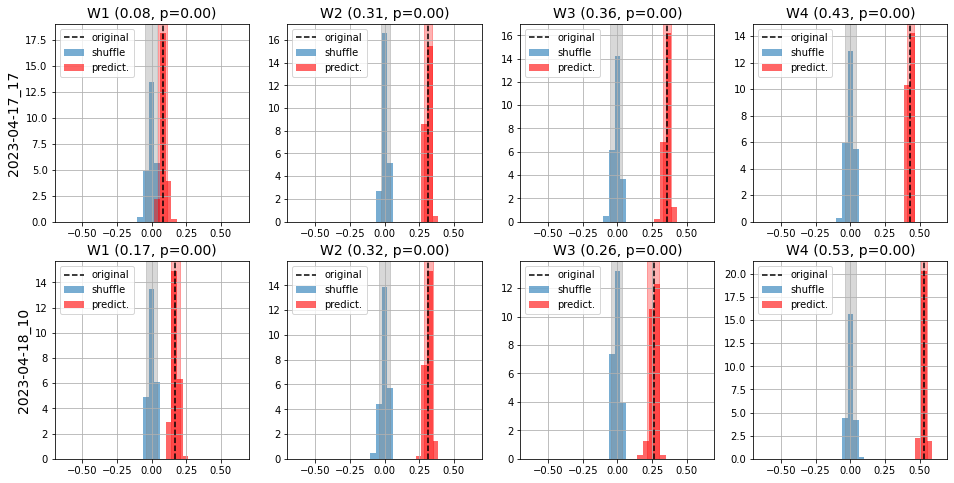

In [45]:
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
bins = np.linspace(-1, 1, 50)

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_fit_file   = os.path.join(source, animal, session, 'analysis', 'MoSeq_W1-W4_GLM.h5')
    
    collected = {}
    with h5py.File(moseq_fit_file, 'r') as f:
        for grp in f:
            collected[grp] = {}
            collected[grp]['corr_glm_fit_orig'] = np.array(f[grp]['corr_glm_fit_orig'])
            collected[grp]['glm_fit_params']    = np.array(f[grp]['glm_fit_params'])
            collected[grp]['glm_fit_pvalues']   = np.array(f[grp]['glm_fit_pvalues'])
            collected[grp]['corr_glm_fit_shuf'] = np.array(f[grp]['corr_glm_fit_shuf'])
            collected[grp]['corr_glm_fit_chun'] = np.array(f[grp]['corr_glm_fit_chun'])

    for j, w_i in enumerate(collected.keys()):
        corr = collected[w_i]['corr_glm_fit_orig'][0]
        pval = collected[w_i]['corr_glm_fit_orig'][1]
        corr_mx_shuf = collected[w_i]['corr_glm_fit_shuf']
        corr_mx_chun = collected[w_i]['corr_glm_fit_chun']

        min_pval = 0.99  # select some or all
        coeffs_shuf = corr_mx_shuf[corr_mx_shuf[:, 1] < min_pval][:, 0]
        coeffs_chun = corr_mx_chun[corr_mx_chun[:, 1] < min_pval][:, 0]

        ax = axes[i][j]
        ax.hist(coeffs_shuf, bins=bins, alpha=0.6, density=True, label='shuffle', color='tab:blue')
        ax.hist(coeffs_chun, bins=bins, alpha=0.6, density=True, label='predict.', color='red')
        ax.axvspan(np.percentile(coeffs_shuf, 5), np.percentile(coeffs_shuf, 95), alpha=0.3, color='gray')
        ax.axvspan(np.percentile(coeffs_chun, 5), np.percentile(coeffs_chun, 95), alpha=0.3, color='red')
        ax.axvline(coeffs_chun.mean(), color='black', ls='--', label='original')
        ax.set_xlim(-0.7, 0.7)
        ax.grid()
        ax.legend(loc='upper left')
        ax.set_title('%s (%.2f, p=%.2f)' % (w_i, coeffs_chun.mean(), pval), fontsize=14)

        if j == 0:
            ax.set_ylabel('%s' % session[-19:-6], fontsize=14)


## TODO: GLM profiles for diff sessions - are they correlated?